# Comparison of What-if-tool and AIX/AIF 360

**Content:**
1. Introduction
1. COMPAS Dataset
1. Data Preprocessing
1. What if Tool
    * Logistic Regression
    * DNN Classifier
    * Examples
1. AI Explainability & Fairness 360
    1. AI Explainability 360
        * Logistic Rule Regression
        * Neural Net
    2. AI Fairness 360
1. Conclusion


## 1. Introduction

Machine learning is increasingly being deployed for decision-making and predictions within consequential domains that are affected by anti-discrimination laws due to the sensitive nature of the processed data These areas are for instance recruiting, criminal justice, credit scoring and education. The application of machine learning in these fields generally has the aim to make the respective prediction processes more objective as a substitute for human decision-making. However, the blind application of machine learning can even amplify existing biases in the historic training data. In case the data used for training the machine learning algorithm is biased, the resulting model will learn these biases and perpetuate discriminatory decisions against protected groups into the future. Hence there is a growing demand for explainable machine learning that detects and mitigates these biases.

In this notebook we will investigate tools from Google (What-If Tool) and IBM (AIX360/AIF360), which enables you to explain your data and model. The experiments will be conducted on the COMPAS data set collected by ProPublica and will be based on existing walkthroughs of the official documentation.

## 2. COMPAS Dataset

COMPAS stands for ‘Correctional Offender Management Profiling for Alternative Sanctions’ and is a risk assesment algorithm developed by Nortpoint,Inc. that incorporates the criminal records and demographic data to assess when a individuum is more likely to become a recidivist. Based on this score ProPublica collected data of all inmates from Broward County from 2013 to 2014 and released the [COMPAS dataset](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis).

In some states the COMPAS risk scores can be considered by judges during sentencing. The first time COMPAS was developed in 1998 and has been revised over the years as the knowledge base of criminology has grown and gets periodically updated. COMPAS is measuring both types of risk, dynamic risk(criminogenic risk) and static risk (historical risk). The risk assessment based on three types of scales.
* **Pretrial Release Risk Scale:** current and pending charges, prior arrest history, previous pretrial failure, residential stability, employment status, community ties, and substance abuse are significant indicators affecting pretrial scores. 
* **General Recidivism Scale:** created to predict new criminal offenses after release of the prison. This scale use an individual criminal history. 
* **Violent Recidivism Scale:** this scale is designed to predict violent offenses based on their history of violence and non-compliance. 

The problem in this dataset is that African-American people pose a higher risk than caucasian people which are rated with a lower risk. The ProPublica investigation found that only 20% of the predicted recidivist actually commit a crime after release. Therefor we will examine the predictions of models trained on this skewed dataset with What-If Tool and AI Fairness & Explainability 360. The target variable is repeat offenders within two years of discharge.

## 3. Preprocessing

In [1]:
# general
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

# preprocessing
from datetime import datetime

# What if tool
import tensorflow as tf
import functools
from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget

# AIX
import torch
from aix360.algorithms.protodash import ProtodashExplainer
from sklearn.preprocessing import OneHotEncoder

# AIF
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

c:\users\florian\anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\tensorf

In [2]:
# load COMPAS dataset
dataset = pd.read_csv("./data/compas-scores-two-years.csv")
display(Markdown("#### Before Cleaning"))
display(dataset)

#### Before Cleaning

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


Before running our models on the dataset we preprocess our data. Not all fields are relevant and we end up with following fields for our analysis.

| Field                   | Description                             | Attributes                             |
| ------------------------|:---------------------------------------:| --------------------------------------:|
| age                     | Age of detainee                         | positive integer                       |
| c_charge_degree         | crime degree                            | F=Felony, M=Misdemeanors               |
| race                    | Ethnic group                            | African-American, Caucausian, ...         |
| age_cat                 | Age categorized                         | age < 25, 25 <= age > 45 and 45 <= age |
| score_text              | Risk of Recidivism categorized          | Low (1-3), Medium (4-7) or High (8-10) |
| sex                     | Gender                                  | Female or Male                         |
| priors_count            | Number of prior criminal records        | positive integer                       |
| days_b_screening_arrest | Difference between charge and crime date | Integer                                |
| decile_score            | Risk of Recidivism                      | 1-10                                   |
| two_year_recid          | Criminal recidivism within two years after release | True/False                             | 
| c_jail_in               | Date of imprisonment                    | Date                                   |
| c_jail_out              | Date of Release                         | Date                                   |

Out **target** variable is 'two year recid', which is True if there is a criminal recidivism within two years and else False. Due to missing data we also perform some data cleaning to our dataset:
* We simplify the time in jail of the detainee in a new attribute 'length_of_stay'.
* We filter samples with 'days_b_screening_arrest' lesser or greater than 30. There is a high possibility that we don't have the right offense if the difference between charge date and crime date is bigger than 30 days.
* Offenses with c_charge_degree = 0 (e.g. traffic offense) are not relevant and filtered out.
* We filter samples with missing input in the field 'score_text'.
* We filter samples that have a negative integer in the field 'length_of_stay'.

After filtering we end up with approximately 1200 samples less.

In [3]:
# Preprocessing

jupyter_feat = [ 'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'two_year_recid', 'c_jail_in', 'c_jail_out']
dataset = dataset.filter(items=jupyter_feat)

# transformation
dataset['length_of_stay'] = (pd.to_datetime(dataset['c_jail_out']) - pd.to_datetime(dataset['c_jail_in'])).dt.days

# filter
dataset = dataset.loc[dataset['days_b_screening_arrest'] <= 30]
dataset = dataset.loc[dataset['days_b_screening_arrest'] >= -30]
# dataset = dataset.loc[dataset['is_recid'] != -1]
dataset = dataset.loc[dataset['c_charge_degree'] != 'O']
dataset = dataset.loc[dataset['score_text'] != 'N/A']
dataset = dataset.loc[dataset['length_of_stay'] >= 0] # Dauer im Gefängnis kann nicht negativ sein

# type conversion
dataset['length_of_stay'] = dataset['length_of_stay'].astype('int64')

# drop irrelevant columns
dataset.drop(columns=['c_jail_in', 'c_jail_out'], inplace=True)

In [4]:
display(Markdown("#### After Cleaning"))
print("Dataset has %i samples and %i features after cleaning" % (dataset.shape[0], dataset.shape[1]))
display(dataset)

#### After Cleaning

Dataset has 5989 samples and 11 features after cleaning


,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,two_year_recid,length_of_stay
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,10
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,1
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,6
...,...,...,...,...,...,...,...,...,...,...,...
7209,23,F,African-American,Less than 25,Medium,Male,0,-1.0,7,0,1
7210,23,F,African-American,Less than 25,Low,Male,0,-1.0,3,0,1
7211,57,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,1
7212,33,M,African-American,25 - 45,Low,Female,3,-1.0,2,0,1


In [5]:
# show some distribution stats

c = dataset['age_cat'].value_counts(dropna=False)
p = dataset['age_cat'].value_counts(dropna=False, normalize=True) * 100
age_result = pd.concat([c,p], axis=1, keys=['counts', '%'])

c = dataset['sex'].value_counts(dropna=False)
p = dataset['sex'].value_counts(dropna=False, normalize=True) * 100
sex_result = pd.concat([c,p], axis=1, keys=['counts', '%'])

c = dataset['race'].value_counts(dropna=False)
p = dataset['race'].value_counts(dropna=False, normalize=True) * 100
race_result = pd.concat([c,p], axis=1, keys=['counts', '%'])

males = dataset.loc[dataset['sex'] == 'Male']
c = males['race'].value_counts(dropna=False)
p = males['race'].value_counts(dropna=False, normalize=True) * 100
males_race_result = pd.concat([c,p], axis=1, keys=['counts', '%'])

females = dataset.loc[dataset['sex'] == 'Female']
c = females['race'].value_counts(dropna=False)
p = females['race'].value_counts(dropna=False, normalize=True) * 100
females_race_result = pd.concat([c,p], axis=1, keys=['counts', '%'])

display(Markdown("#### Distribution of sensitive features <br><br>"))
display(Markdown("**Age:**"), age_result, Markdown("***"))
display(Markdown("**Gender:**"), sex_result, Markdown("***"))
display(Markdown("**Race:**"), race_result, Markdown("***"))
display(Markdown("**Race (only males):**"), males_race_result, Markdown("***"))
display(Markdown("**Race (only females):**"), females_race_result, Markdown("***"))

#### Distribution of sensitive features <br><br>

**Age:**

,counts,%
25 - 45,3424,57.171481
Less than 25,1312,21.906829
Greater than 45,1253,20.921690


***

**Gender:**

,counts,%
Male,4849,80.965103
Female,1140,19.034897


***

**Race:**

,counts,%
African-American,3086,51.527801
Caucasian,2032,33.928870
Hispanic,496,8.281850
Other,333,5.560194
Asian,31,0.517616
Native American,11,0.183670


***

**Race (only males):**

,counts,%
African-American,2558,52.753145
Caucasian,1562,32.212827
Hispanic,415,8.558466
Other,276,5.691895
Asian,29,0.598061
Native American,9,0.185605


***

**Race (only females):**

,counts,%
African-American,528,46.315789
Caucasian,470,41.228070
Hispanic,81,7.105263
Other,57,5.000000
Native American,2,0.175439
Asian,2,0.175439


***

## 4. What-If Tool (WIT)


WIT is an application that enables you to investigate machine learning models with minimal coding. It supports Tensorflow and Python-accessible models. Additional you can use it via tensorboard or Jupyter/Colaboratory notebooks. It provides an easy to use interface with various algorithms to visualize, compare and adjust datapoints or models.

In this notebook we embedded What-If tool via the pip package [witwidget](https://pypi.org/project/witwidget/). There are other options to set up WIT (e.g. docker, tensorboard, etc.) and even Google Cloud supports this addon. You can find out more about this and also different examples/walkthroughs [here](https://pair-code.github.io/what-if-tool/).

First up we split the data in train and test and define some helper methods. After this we run a logistic regression and a DNN Classifier on our dataset and compare them with the WIT.

In [6]:
# split in train and test
x_test = dataset.sample(frac=1/5)
index_mask = dataset.index.isin(x_test.index)
index_mask = [not i for i in index_mask]
x_train = dataset[index_mask]

In [7]:
# Several helper methods copied from the official Income classification example
# https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_Model_Comparison.ipynb

def df_to_examples(df, columns=None):
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(str(row[col]).encode('utf-8'))
        examples.append(example)
    return examples

# An input function for providing input to a model from tf.Examples
def tfexamples_input_fn(examples, feature_spec, label, mode=tf.estimator.ModeKeys.EVAL,
                       num_epochs=None, 
                       batch_size=64):
    def ex_generator():
        for i in range(len(examples)):
            yield examples[i].SerializeToString()
    dataset = tf.data.Dataset.from_generator(
      ex_generator, tf.dtypes.string, tf.TensorShape([]))
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
    return dataset

# Parses Tf.Example protos into features for the input function.
def parse_tf_example(example_proto, label, feature_spec):
    parsed_features = tf.parse_example(serialized=example_proto, features=feature_spec)
    target = parsed_features.pop(label)
    return parsed_features, target

def create_feature_spec(df, columns=None):
    feature_spec = {}
    if columns == None:
        columns = df.columns.values.tolist()
    for f in columns:
        if df[f].dtype is np.dtype(np.int64):
            feature_spec[f] = tf.FixedLenFeature(shape=(), dtype=tf.int64)
        elif df[f].dtype is np.dtype(np.float64):
            feature_spec[f] = tf.FixedLenFeature(shape=(), dtype=tf.float32)
        else:
            feature_spec[f] = tf.FixedLenFeature(shape=(), dtype=tf.string)
    return feature_spec

def create_feature_columns(columns, feature_spec):
    ret = []
    for col in columns:
        if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
            ret.append(tf.feature_column.numeric_column(col))
        else:
            ret.append(tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(col, list(dataset[col].unique()))))
    return ret

In [8]:
# Set the column in the dataset you wish for the model to predict
label_column = 'two_year_recid'

input_features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'length_of_stay']

# Create a list containing all input features and the label column
features_and_labels = input_features + [label_column]

### Logistic Regression & DNN Classifier

We first define our linear classifier (logistic regression) and our non-linear classifier (DNN). We train both models on our training data and evaluate them with WIT on our testing data.

In [9]:
#@title Convert dataset to tf.Example protos {display-mode: "form"}
examples = df_to_examples(x_train)

#@title Create and train the DNN classifier {display-mode: "form"}
tf.logging.set_verbosity(tf.logging.DEBUG)
num_steps = 2000  #@param {type: "number"}
num_steps_2 = 2000  #@param {type: "number"}

feature_spec = create_feature_spec(x_train, features_and_labels)

train_inpf = functools.partial(tfexamples_input_fn, examples, feature_spec, label_column)

# define and train linear model
lin_classifier = tf.estimator.LinearClassifier(
    feature_columns=create_feature_columns(input_features, feature_spec))
lin_classifier.train(train_inpf, steps=num_steps)

# define and train non-linear model
nonlin_classifier = tf.estimator.DNNClassifier(
    feature_columns=create_feature_columns(input_features, feature_spec),
    hidden_units=[128, 64, 32])
nonlin_classifier.train(train_inpf, steps=num_steps_2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Florian\\AppData\\Local\\Temp\\tmpb7bbyi_y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000017502CCDCF8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Var

DEBUG:tensorflow:Transforming feature_column VocabularyListCategoricalColumn(key='score_text', vocabulary_list=('Low', 'Medium', 'High'), dtype=tf.string, default_value=-1, num_oov_buckets=0).
DEBUG:tensorflow:Transforming feature_column IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('Male', 'Female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)).
DEBUG:tensorflow:Transforming feature_column VocabularyListCategoricalColumn(key='sex', vocabulary_list=('Male', 'Female'), dtype=tf.string, default_value=-1, num_oov_buckets=0).
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\Florian\AppData\Local\Temp\tmpb7bbyi_y\model.ckpt.
INFO:tensorflow:loss = 44.36142, step = 1
INFO:tensorf

DEBUG:tensorflow:Transforming feature_column NumericColumn(key='length_of_stay', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None).
DEBUG:tensorflow:Transforming feature_column NumericColumn(key='priors_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None).
DEBUG:tensorflow:Transforming feature_column IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='race', vocabulary_list=('Other', 'African-American', 'Caucasian', 'Hispanic', 'Asian', 'Native American'), dtype=tf.string, default_value=-1, num_oov_buckets=0)).
DEBUG:tensorflow:Transforming feature_column VocabularyListCategoricalColumn(key='race', vocabulary_list=('Other', 'African-American', 'Caucasian', 'Hispanic', 'Asian', 'Native American'), dtype=tf.string, default_value=-1, num_oov_buckets=0).
DEBUG:tensorflow:Transforming feature_column IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='score_text', vocabulary_list=('Low', 'Medium', 'High'), d

INFO:tensorflow:loss = 39.541527, step = 1901 (0.971 sec)
INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\Florian\AppData\Local\Temp\tmpp5msvx0o\model.ckpt.
INFO:tensorflow:Loss for final step: 38.162025.


In [10]:
tool_height_in_px = 600  #@param {type: "number"}

test_examples = df_to_examples(x_test)

# Setup the tool with the test examples and the trained classifier
config_builder = WitConfigBuilder(test_examples).set_estimator_and_feature_spec(
    lin_classifier, feature_spec).set_compare_estimator_and_feature_spec(
    nonlin_classifier, feature_spec).set_label_vocab(['not_two_year_recid', 'two_year_recid'])

In [11]:
# Calling What-If Tool via the witwidget package
# Click Cell -> Current Outputs -> Toggle Scrolling if WIT is not shown as tool_height_in_px
WitWidget(config_builder, height=tool_height_in_px)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not_two_year_recid', 'two_year_recid'], 'ar…

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


### Examples

#### Visualize distribution
If we use a binning on the feature 'race' we can visualize the skewed distribution in our dataset. By far the most people are African-Americans and they also have in contrast to the other races more positive predictions. About half of the samples with the feature {race = African-American} get predicted as true in contrast to the other groups, where around one third gets predicted as true.

<img src="./example_distribution.png" alt="drawing" width="800"/>

#### Search Counterfactual
There is also the functionality to search for counterfactuals of a specific sample. Just click on one sample and choose "Nearest counterfactual". The counterfactual is the nearest (L1 or L2 distance) sample of the group that was contrary predicted from the model.

<img src="./example_counterfactual.png" alt="drawing" width="800"/>

#### Use Fairness Algortihm
In the 'Performance and Fairness' tab are a few standard algorithms for bias mitigation. In the picture below we set the ground truth label to 'two_year_recid' and sliced by the feature 'race'. We chose the 'Equal Opportunity' algorithm that signifies that there is a bias for positive predictions in the African-American group. [Here](https://pair-code.github.io/what-if-tool/ai-fairness.html) you can find more details to those five fairness algorithms.

<img src="./example_fairness.png" alt="drawing" width="800"/>

## 5.A. AI Explainability 360

AI Explainability 360 is an open source toolkit that gives access to various algorithms to comprehend the predictions of your models. There is a growing number of algorithms state of the art based on recent published papers. You can find a documentation of the toolkit [here](https://aix360.readthedocs.io/en/latest/).

In this notebook we installed the official pip package [aix360](https://pypi.org/project/aix360/) and tested two algorithms on simple models trained on our COMPAS dataset. First off we used a given linear model of the package based on the implementation  of the logistic regression class of [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Secondly, we trained our dataset on a two layer neural net implemented in Pytorch and evaluated the results with the [Protodash Explainer](https://aix360.readthedocs.io/en/latest/die.html#aix360.algorithms.protodash.PDASH.ProtodashExplainer).

In [12]:
# try to use existing split
yTrain_raw = x_train.pop('two_year_recid')
dfTrain_raw = x_train
yTest_raw = x_test.pop('two_year_recid')
dfTest_raw = x_test

In [13]:
# Convert few columns so that Feature Binarizer has no problems handeling these
dfTrain_raw['age'] = dfTrain_raw['age'].astype(np.int)
dfTrain_raw['priors_count'] = dfTrain_raw['priors_count'].astype(np.int)
dfTrain_raw['decile_score'] = dfTrain_raw['decile_score'].astype(np.int)

c:\users\florian\anaconda3\envs\aix360\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

### Logistic Rule Regression

This is a given model from the aix360 package that is based on the logistic regression class from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). We first transform our feature to binarize features with the [FeatureBinarizer](https://github.com/IBM/AIX360/blob/master/aix360/algorithms/rbm/features.py) class from aix360. This will create additional features that are either True or False (rules).

In [14]:
# Binarize data and also return standardized ordinal features
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(colCateg=[1,2,3,4,5], negations=True, returnOrd=True)
dfTrain, dfTrainStd = fb.fit_transform(dfTrain_raw)
dfTest, dfTestStd = fb.transform(dfTest_raw)
print(dfTrain.shape)

Skipping column 'length_of_stay': data type cannot be handled
Skipping column 'length_of_stay': data type cannot be handled
Skipping column 'length_of_stay': data type cannot be handled
(4791, 82)


After preprocessing our data we create the [LogisticRuleRegression (LRR)](https://aix360.readthedocs.io/en/latest/dise.html#aix360.algorithms.rbm.logistic_regression.LogisticRuleRegression) model and train it on our dataset. The LLR model has a few explain functions already implemented. Hence we can directly call explain() on our model and get the most important features listed. Additional we can visualize the impact of a feature value for each feature.

In the plotted diagrams below we can evaluate that males are more likely to be predicted as two-year recidivist and also that the impact of prior_count grows linear after prior_count = 2. This indicates that we have probably a shifted distribution in prior counts as a detainee with less then two prior counts is more likely to be predicted as a recidivist than detainess with prior counts between two and ten.

In [15]:
# Instantiate LRR with good complexity penalties and numerical features
from aix360.algorithms.rbm import LogisticRuleRegression
from sklearn.metrics import accuracy_score
lrr = LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)

# Train, print, and evaluate model
lrr.fit(dfTrain, yTrain_raw, dfTrainStd)
print('Training accuracy:', accuracy_score(yTrain_raw, lrr.predict(dfTrain, dfTrainStd)))
print('Test accuracy:', accuracy_score(yTest_raw, lrr.predict(dfTest, dfTestStd)))
print('Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))')
print('where z is a linear combination of the following rules/numerical features:')
dfExplain = lrr.explain()

Training accuracy: 0.6892089334168232
Test accuracy: 0.7186978297161937
Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))
where z is a linear combination of the following rules/numerical features:


In [16]:
# returns a list of features with the most impact for a positive or negative prediction
lrr.explain()

,rule/numerical feature,coefficient
0,(intercept),0.784971
1,priors_count <= 2.00 AND days_b_screening_arre...,-0.939935
2,age > 22.00 AND days_b_screening_arrest <= 0.00,-0.729502
3,priors_count,0.722026
4,age,-0.538052
5,priors_count <= 2.00,0.488433
6,sex,0.40147
7,score_text != High AND days_b_screening_arrest...,-0.395099
8,priors_count <= 1.00,-0.394286
9,score_text == Low AND days_b_screening_arrest ...,-0.349061


({'sex': <Figure size 432x288 with 1 Axes>}, sex    0.024844
 dtype: float64)

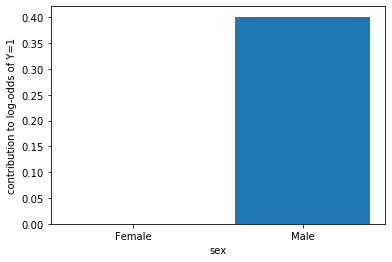

In [17]:
lrr.visualize(dataset, fb, ['sex'])

({'priors_count': <Figure size 432x288 with 1 Axes>}, priors_count    0.153856
 dtype: float64)

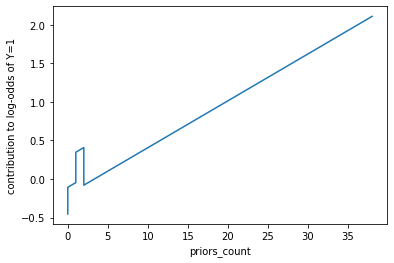

In [18]:
lrr.visualize(dataset, fb, ['priors_count'])

### Neural Net

For the DNN example we will use the [Protodash](https://aix360.readthedocs.io/en/latest/die.html#aix360.algorithms.protodash.PDASH.ProtodashExplainer) algorithm of the aix360 package to evaluate our own defined model. The Protodash algorithm can be used to explain predictions of models or a dataset. In our case we implemented a simple neural net in Pytorch and trained it on our COMPAS dataset. Lastly we made predictions on our test dataset and evaluated the results with the Protodash algorithm.

This algorithm is based on a recently published paper from [Karthik S. Gurumoorthy](https://arxiv.org/pdf/1707.01212.pdf) with involvment of the IBM research team. It basically searches a dataset for n prototypes given your example data by minimizing the maximum mean discrepancy. We use it to find the most similiar n prototypes given one example we have chosen.

In [19]:
# transforms categorical columns in numerical
def encode(X, cat_cols):
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc.fit(X)
    df = pd.DataFrame(enc.transform(X), columns= enc.get_feature_names(cat_cols))
    df.reset_index(drop=True, inplace=True)
    return df

In [20]:
# encode categorical columns with OneHotEncoder from scikit

categorical_columns = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']

# extract categorical columns in a new dataframe
train_x_cat = dfTrain_raw.loc[:, categorical_columns]
test_x_cat = dfTest_raw.loc[:, categorical_columns]

# remove categorical columns
train_x = dfTrain_raw.drop(columns=categorical_columns)
test_x = dfTest_raw.drop(columns=categorical_columns)

# reset index for concat
train_x.reset_index(drop=True, inplace=True)
test_x.reset_index(drop=True, inplace=True)

# concat again with encoded categorical columns
train_x = pd.concat([train_x, encode(train_x_cat, categorical_columns)], axis=1)
test_x = pd.concat([test_x, encode(test_x_cat, categorical_columns)], axis=1)

In [21]:
# helper method to organize features and labels in a tuple for pytorch dataloader
def merge_features_labels(x, y):
    merge = []
    for i in range(x.shape[0]):
        tup = (torch.Tensor(x[i]),torch.Tensor(y[i]))
        merge.append(tup)
    return merge

In [22]:
input_dim = train_x.shape[1]

xTrain = torch.Tensor(np.array(train_x))
yTrain = torch.Tensor(np.array(yTrain_raw.values.reshape(yTrain_raw.shape[0],1)))

xTest = torch.Tensor(np.array(test_x))
yTest = torch.Tensor(np.array(yTest_raw.values.reshape(yTest_raw.shape[0],1)))

# organize data in a tuples
train_dat = merge_features_labels(np.array(train_x), np.array(yTrain_raw.values.reshape(yTrain_raw.shape[0],1)))

# define model
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Sigmoid()
)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# model pipeline
epochs = 10
batch_size = 128

dataloader = torch.utils.data.DataLoader(
    train_dat,
    batch_size=batch_size,
    shuffle=True
)

# train n epochs our model
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
        # print statistics
    running_loss += loss.item()
    running_loss = 0.0
    y_hat_test = model(inputs)
    y_hat_test_class = np.where(y_hat_test.detach().numpy()<0.5, 0, 1)
    test_accuracy = np.sum(labels.detach().numpy().reshape(-1,1)==y_hat_test_class) / len(labels.detach().numpy())
    print('Epoch [%d, %5d] loss: %.3f, Accuracy: %.3f' % (epoch + 1, epochs, running_loss / 2000, test_accuracy))

Epoch [1,    10] loss: 0.000, Accuracy: 0.582
Epoch [2,    10] loss: 0.000, Accuracy: 0.673
Epoch [3,    10] loss: 0.000, Accuracy: 0.600
Epoch [4,    10] loss: 0.000, Accuracy: 0.636
Epoch [5,    10] loss: 0.000, Accuracy: 0.818
Epoch [6,    10] loss: 0.000, Accuracy: 0.655
Epoch [7,    10] loss: 0.000, Accuracy: 0.673
Epoch [8,    10] loss: 0.000, Accuracy: 0.764
Epoch [9,    10] loss: 0.000, Accuracy: 0.618
Epoch [10,    10] loss: 0.000, Accuracy: 0.691


After we trained our model we can now evaluate it with the [Protodash](https://aix360.readthedocs.io/en/latest/die.html#aix360.algorithms.protodash.PDASH.ProtodashExplainer) algorithm. We first store all predictions of our training data in 'p_train' and filter only the good examples (where a detainee is in two years recid). Then we pick a random sample from our test dataset and print it.

After this we run the ProtodashExplainer() with our chosen random sample, all good examples of our training dataset and a number of prototypes that we want the algorithm to return. Protodash searches for the most similar  samples given our chosen random sample. Lastly, we print the most similar prototypes.

In [23]:
# model evaluation

# predict a datapoint
p_train = model(xTrain) # Use trained neural network to predict train points
p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((xTrain.detach(), p_train.detach()))

mask = (z_train[:,-1]>0.5)

# array with the good predicted samples
z_train_good = z_train[mask]
# array with real values of the good predicted samples
y_z_train_good = yTrain[mask].detach().numpy()

In [24]:
idx = 20

class_names = ['not_recid', 'recid']

X = xTest[idx].reshape((1,) + xTest[idx].shape)

print("Chosen Sample:", idx)
# print("Prediction made by the model:", class_names[np.argmax(model(X).detach())]) # 0.5
print("Prediction made by the model:", class_names[1 if model(X).detach() > 0.5 else 0]) # 0.5
print("Prediction probabilities:", model(X).detach())
print("")

# attach the prediction made by the model to X
X = np.hstack((X, model(X).detach().reshape((1,1))))

Chosen Sample: 20
Prediction made by the model: recid
Prediction probabilities: tensor([[0.9999]])



In [25]:
# define columns to create dataframes
cols = train_x.columns
df_tmp = pd.Index(['two_year_recid']) 
cols = cols.append(df_tmp)

In [26]:
# Show chosen example
dfx = pd.DataFrame.from_records(X.astype('double')) # Create dataframe with original feature values
dfx.iloc[0,21] = class_names[1 if dfx.iloc[0,21] > 0.5 else 0]
dfx.columns = cols
dfx['gt_two_year_recid'] = class_names[1 if yTest[idx] > 0.5 else 0]
dfx['Weight'] = 1.0
dfx.transpose()

,0
age,33
priors_count,14
days_b_screening_arrest,-1
decile_score,10
length_of_stay,1
c_charge_degree_F,1
c_charge_degree_M,0
race_African-American,1
race_Asian,0
race_Caucasian,0


In [27]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_train_good, m=5) # Return weights W, Prototypes S and objective function values

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.0542e+03 -1.3334e+07  2e+03  1e+00  1e+00
 2:  1.1446e+03 -1.4897e+07  2e+03  1e+00  1e+00
 3:  1.6845e+03 -2.2851e+07  3e+03  1e+00  1e+00
 4:  2.9933e+03 -3.6733e+07  6e+03  1e+00  1e+00
 5:  3.0081e+03 -3.6886e+07  6e+03  1e+00  1e+00
 6:  3.2222e+03 -5.7534e+07  1e+04  1e+00  1e+00
 7: -9.2386e+01 -9.0073e+07  2e+04  1e+00  1e+00
 8:  1.0664e+02 -2.2897e+08  5e+04  1e+00  1e+00
 9:  1.7970e+02 -6.8443e+08  1e+05  1e+00  1e+00
10:  3.6337e+02 -4.1474e+09  9e+05  1e+00  1e+00
11:  8.0863e+02 -1.4243e+11  3e+07  1e+00  1e+00
12:  8.0769e+02 -3.3021e+14  1e+11  1e+00  1e+00
13:  2.2315e+10 -3.4485e+21  3e+21  4e-13  2e+01
14:  2.2315e+10 -3.4485e+19  3e+19  4e-15  2e-01
15:  2.2315e+10 -3.4485e+17  3e+17  1e-16  2e-03
16:  2.2315e+10 -3.4486e+15  3e+15  6e-17  2e-05
17:  2.2313e+10 -3.4527e+13  3e+13  2e-16  2e-07
18:  2.2105e+10 -3.8633e+11  4e+11  2e-16  1e-07
19:  1.2013e+10 -2.52

c:\users\florian\anaconda3\envs\aix360\lib\site-packages\cvxopt\coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\cvxopt\coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\cvxopt\coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
c:\users\florian\anaconda3\envs\aix360\lib\site-packages\cvxopt\coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


In [28]:
dfs = pd.DataFrame.from_records(z_train_good[S, :].astype('double'))
# make preds and get gt

RP=[]
GT=[]
for i in range(S.shape[0]):
    RP.append(class_names[1 if z_train_good[S[i], -1] > 0.5 else 0]) # Append class names
    GT.append(class_names[int(y_z_train_good[S[i]])])
dfs[21] = RP
dfs.columns = cols
dfs['gt_two_year_recid'] = GT
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs = pd.concat([dfx, dfs])
dfs.reset_index(inplace=True, drop=True)
display(Markdown("#### Comparison"))
display(Markdown("Index 0 = Chosen Sample"))
display(Markdown("Index 1-5 = Most similiar prototypes"))
display(dfs.transpose())

#### Comparison

Index 0 = Chosen Sample

Index 1-5 = Most similiar prototypes

,0,1,2,3,4,5
age,33,27,43,20,27,64
priors_count,14,12,3,0,27,13
days_b_screening_arrest,-1,-1,21,-2,0,-1
decile_score,10,8,3,10,10,6
length_of_stay,1,1,2,0,0,1
c_charge_degree_F,1,1,0,0,0,1
c_charge_degree_M,0,0,1,1,1,0
race_African-American,1,1,0,0,1,1
race_Asian,0,0,0,0,0,0
race_Caucasian,0,0,0,1,0,0


## 5.B. AI Fairness 360

For bias mitigation there is an additional package next to [AI Explainability 360](https://aif360.mybluemix.net/). AI Fairness 360 comes includes 10 algorithms that can be used in pre-, in- or post-processing.


In the package there are some datasets already included. To use the algorithms you need to transform you data into a [Structured Dataset](https://aif360.readthedocs.io/en/latest/modules/datasets.html#structured-dataset). Luckily the COMPAS dataset is already available via the package and we can skip this step. First we load the COMPAS dataset and define our privileged and unprivileged groups. In this case we are sensible that African-Americans get discriminated from our model and Caucasians favored. So we set African-Americans as the unprivileged and Caucasians as the privileged group.

After that we evaluate the bias with the already included [BinaryLabelDatasetMetric](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric) the difference in the mean outcomes regarding these groups. It seems there is quite a big difference around 10% between the mean outcomes of African-Americans and Caucasians. Therefor we use one of 10 metrics from AI Fairness [Reweighing](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#aif360.algorithms.preprocessing.Reweighing). Reweighing is a preprocesing step to mitigate bias. To use this algorithm we need to have the dataset defined as a [Structured Dataset](https://aif360.readthedocs.io/en/latest/modules/datasets.html#structured-dataset) as the weights of the different feature attributes will be adjusted. After executing reweighing, we test the difference in the mean outcomes between our groups again and find that the bias has been completely eliminated.

Note that this works perfectly if we test the exact same data again, but if there is a dataset shift, we would need to adjust the weights again for complete bias reduction.

In [29]:
dataset_orig = CompasDataset()

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'race': 1}] # African-American
unprivileged_groups = [{'race': 0}] # Caucasian
type(dataset_orig)

c:\users\florian\anaconda3\envs\aix360\lib\site-packages\aif360\datasets\standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))


aif360.datasets.compas_dataset.CompasDataset

In [30]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.119411


In [31]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

In [32]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


## 6. Conclusion

Both open source tool kits provide multiple algorithms for visualization, bias mitigation and analyses of individual samples. WIT offers a graphical interface and is easy to learn for non-technical and technical users. On the other side AIF360/AIX360 lacks in those areas, but instead has a growing number of algorithms based on recent published papers. Further is AIF360/AIX360 a library and hence quite more flexible as we can call each function directly and don't have to interact via a graphical user interface like in WIT. 

In our conclusion there is no winner as both tools have their own user base. If you don't need to be an expert in explaining the functionality of your model and only want to have a rough overview about biases and your data distribution WIT is sufficient. On the other side if the priority of your project is to eliminate any discrimination of your model AIF360/AIX360 offers you more functionalities and comes with a bunch of scientific papers that can support your decision making.

Nevertheless, we as model developers should be more sensible about discriminating models and be able to explain how they make predictions or what their weaknesses/disadvantages are. This requires that we understand our data and model for which WIT and AIF360/AIX360 offers us a reasonable framework.